In [1]:
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append('..')
import gym
import yowie_gym

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# UAV Platooning

In [3]:
import yowie_gym.tarski.uav_platoon

In [4]:
env = gym.make('UAV-Platooning-0000-v1')

## Passive Dynamics ($U$ = 0)

In [5]:
frames = []
x0 = env.reset()
S_zero = [x0]
g_zero = []
while True:
    u = np.zeros(env.action_space.shape[0])
    frames += [ env.render(mode="rgb_array") ]
    x, r, done, info = env.step(u)
    S_zero.append(x)
    g_zero.append(r)
    if done: break
S_zero = np.hstack(S_zero)
g_zero = np.asarray(g_zero, dtype=np.float64)
J_zero = np.asarray([ np.sum(g_zero[k:]) for k in range(g_zero.shape[0])], dtype=np.float64)

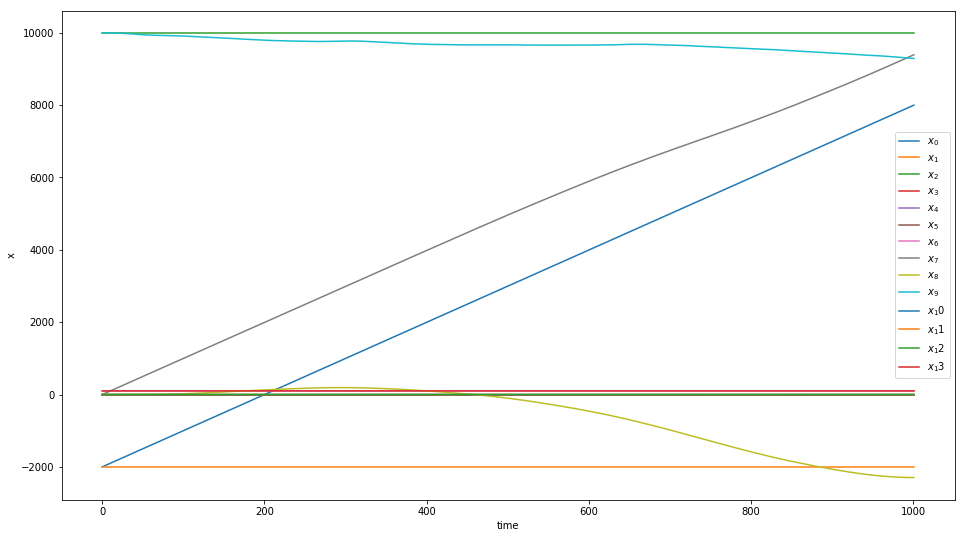

In [6]:
fig, ax = plt.subplots(1,1, figsize=(16,9))
ax.set_xlabel('time')
ax.set_ylabel('x')
for x_dim in range(S_zero.shape[0]):
    # Plot a single line
    xs = np.linspace(0, S_zero.shape[1], num=S_zero.shape[1])
    ys = S_zero[x_dim,:]
    ax.plot(xs, ys, label='$x_{}$'.format(x_dim))
ax.legend()

## MPC

In [7]:
#env.unwrapped.solver.x0 = x.tolist()
#env.unwrapped.solver.start()
#env.unwrapped.solver.solve()
#X, U, J, iteration = env.unwrapped.solver.trajectory
#k, K = env.unwrapped.solver.control_law

In [8]:
x0 = env.reset()
S_mpc = [x0]
U_mpc = []
g_mpc = []
J_mpc = 0.0
x = x0
total_time = 0.0
while True:
    env.unwrapped.solver.x0 = x.tolist()
    env.unwrapped.solver.start()
    env.unwrapped.solver.solve()
    X, U, J, iteration = env.unwrapped.solver.trajectory
    total_time += env.unwrapped.solver.elapsed_time
    u = np.array(U[0]).reshape(env.action_space.shape)
    U_mpc.append(u)
    x, r, done, info = env.step(u)
    S_mpc.append(x)
    g_mpc.append(r)
    J_mpc += r
    if done: break

In [9]:
print('MPC over sim: {} msecs'.format(total_time))

MPC over sim: 65109.0 msecs


In [10]:
S_mpc = np.hstack(S_mpc)
U_mpc = np.hstack(U_mpc)
g_mpc = np.asarray(g_mpc, dtype=np.float64)

### Trajectory on the $x$-$y$ plane

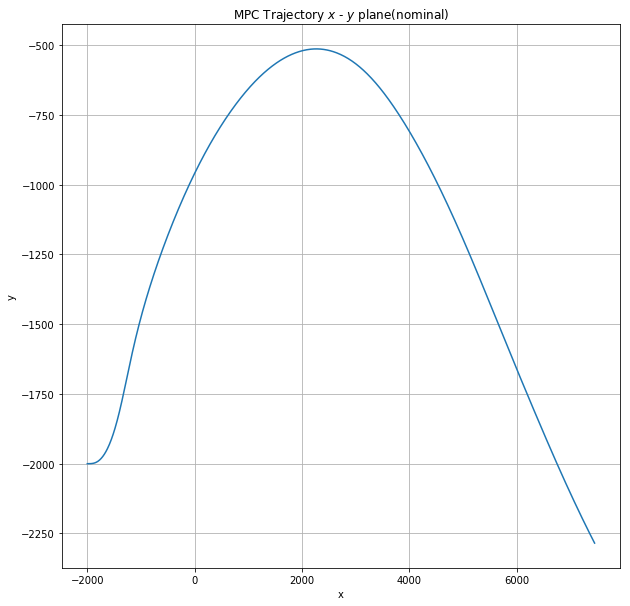

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
title = 'MPC Trajectory $x$ - $y$ plane(nominal)'
ax.grid(True)
ax.set_title(title)
ax.set_xlabel('x')
ax.set_ylabel('y')
# Plot a single line
xs = S_mpc[0,:]
ys = S_mpc[1,:]
ax.plot(xs, ys)

### State variables temporal evolution

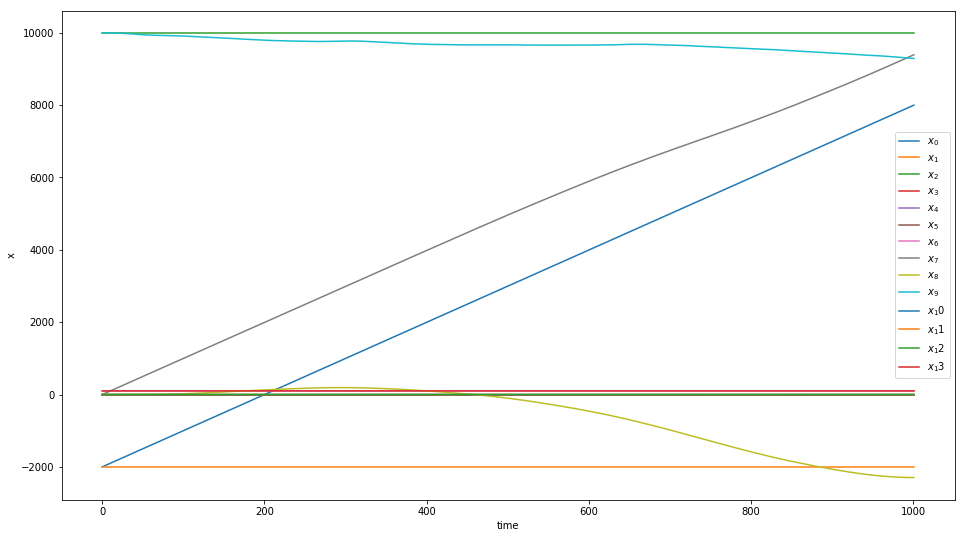

In [12]:
fig, ax = plt.subplots(1,1, figsize=(16,9))
ax.set_xlabel('time')
ax.set_ylabel('x')
for x_dim in range(S_zero.shape[0]):
    # Plot a single line
    xs = np.linspace(0, S_mpc.shape[1], num=S_mpc.shape[1])
    ys = S_zero[x_dim,:]
    ax.plot(xs, ys, label='$x_{}$'.format(x_dim))
ax.legend()

### Control input sequence

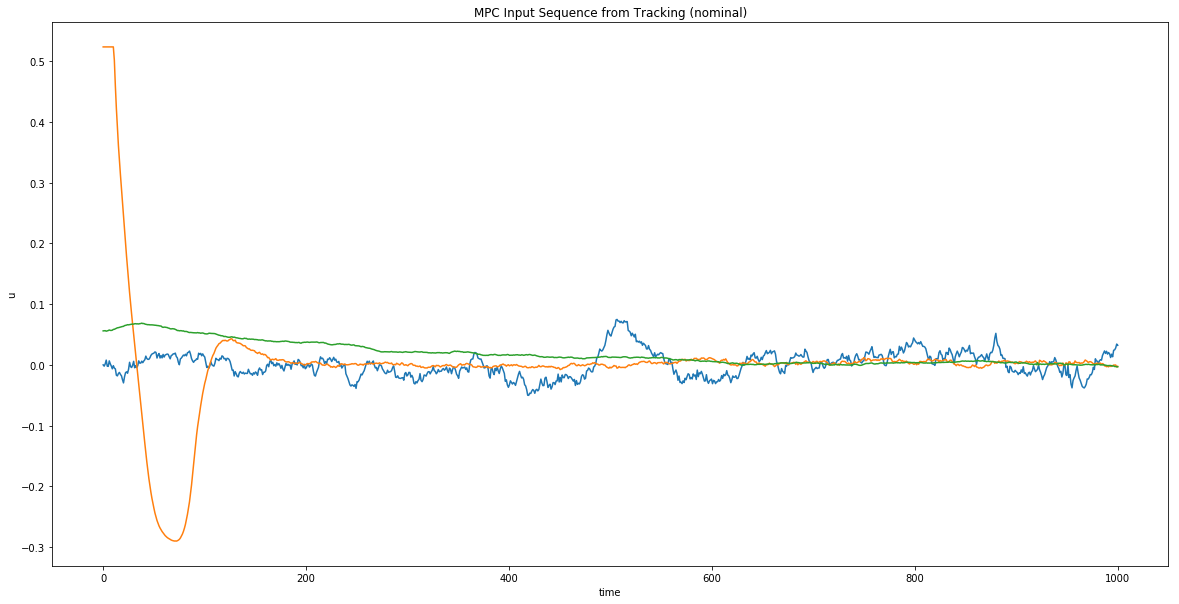

In [13]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
title = 'MPC Input Sequence from Tracking (nominal)'

ax.set_title(title)
ax.set_xlabel('time')
ax.set_ylabel('u')
for x_dim in range(U_mpc.shape[0]):
    # Plot a single line
    xs = np.linspace(0, U_mpc.shape[1], num=U_mpc.shape[1])
    ys = U_mpc[x_dim,:]
    ax.plot(xs, ys)

### MPC costs

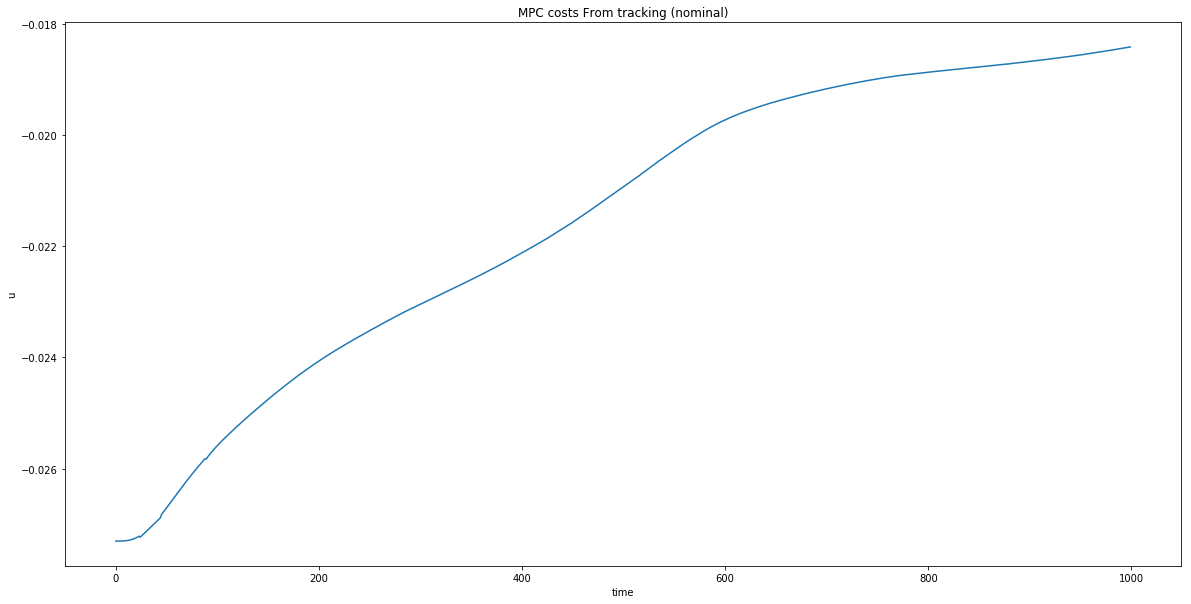

In [14]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
title = 'MPC costs From tracking (nominal)'

ax.set_title(title)
ax.set_xlabel('time')
ax.set_ylabel('u')
xs = np.arange(len(g_mpc))
ys = g_mpc
ax.plot(xs, ys)